# Assigment 3 - GraphSage

For this assignment, we'll go through a simple example of how to use GraphSage's algorithm in a similar fashion as [Assignment 1](https://github.com/thmosqueiro/graph-attention-net-genomics-public/blob/main/notebooks/Chapter%201%20-%20Pytorch%20Intro.ipynb). Like before, getting 10 pts in this assignment gives you 100% grade. There are two extra points you can get if you want to go above and beyond (or if you want to catch up from a previous assignment).

For more info:
* https://snap.stanford.edu/graphsage/
* https://arxiv.org/pdf/1706.02216

The original publication uses Tensorflow. PyG (Pytorch Geommetric) implements solutions for Graph NNs, and include GraphSage:
* https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GraphSAGE.html
Here's their implementation of GraphSage (which is reproduced below):
* https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/basic_gnn.html#GraphSAGE

In case you need to install pyg:

In [1]:
# imports
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

In [2]:
# model definition
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

In [3]:
# dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


* **Question 1 (1 pt):** Visualize the training data using a classical dimensionality reduction technique.

/home/vdubey/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


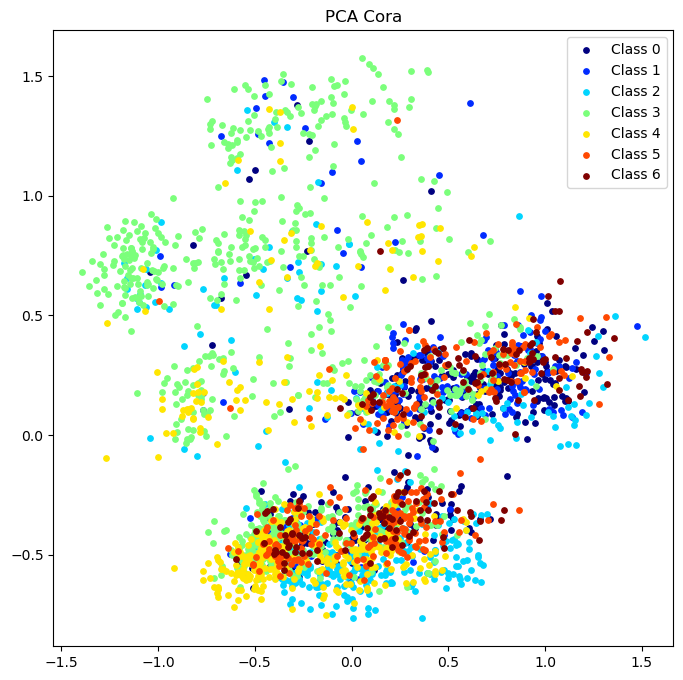

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

data = dataset.data

features = data.x.numpy()
labels = data.y.numpy()

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

unique_labels = np.unique(labels)

cmap = plt.get_cmap('jet', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]

plt.figure(figsize=(8, 8))
for i, label in enumerate(unique_labels):
    plt.scatter(reduced_features[labels == label, 0], reduced_features[labels == label, 1], color=colors[i], label=f'Class {label}', s=15)

plt.legend()
plt.title("PCA Cora")
plt.show()

We can some seperations within the classes and how some classes are bundled together. But there do not seem to be any super distinct boundaries in two dimensions.

Use `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')` if you'd like to use CUDA.

In [5]:
# Setting up the model
model = GraphSAGE(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

* **Question 2 (1 pt):** What's "weight decay"?

Weight decay is a parameter used to regularize the weights of the model. This is done by adding (weight_decay * the norm of the parameters) to the loss function. By keeping the weights small, the model is able to mitigate overfitting and avoid potential exploding gradient issues.

In [6]:
# Defining a training step
def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Defining a test step
def test():
    model.eval()
    with torch.no_grad():
        out = model(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

In [7]:
# Run one iteration
train()
acc = test()
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.5590


/home/vdubey/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [8]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    loss = train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}; Loss on epoch {epoch+1}: {loss}')

Accuracy on epoch 1: 0.659; Loss on epoch 1: 1.5852426290512085
Accuracy on epoch 2: 0.681; Loss on epoch 2: 1.2680866718292236
Accuracy on epoch 3: 0.697; Loss on epoch 3: 0.9936152696609497
Accuracy on epoch 4: 0.703; Loss on epoch 4: 0.7661663293838501
Accuracy on epoch 5: 0.708; Loss on epoch 5: 0.5850768089294434
Accuracy on epoch 6: 0.707; Loss on epoch 6: 0.44534966349601746
Accuracy on epoch 7: 0.705; Loss on epoch 7: 0.3397785425186157
Accuracy on epoch 8: 0.708; Loss on epoch 8: 0.26093313097953796
Accuracy on epoch 9: 0.707; Loss on epoch 9: 0.20228874683380127
Accuracy on epoch 10: 0.706; Loss on epoch 10: 0.15860924124717712
Accuracy on epoch 11: 0.709; Loss on epoch 11: 0.12590816617012024
Accuracy on epoch 12: 0.706; Loss on epoch 12: 0.10124097019433975
Accuracy on epoch 13: 0.702; Loss on epoch 13: 0.0824669748544693
Accuracy on epoch 14: 0.701; Loss on epoch 14: 0.06803998351097107
Accuracy on epoch 15: 0.703; Loss on epoch 15: 0.05684380605816841
Accuracy on epoch 16

In [9]:
res = {}
res['standard'] = accuracy

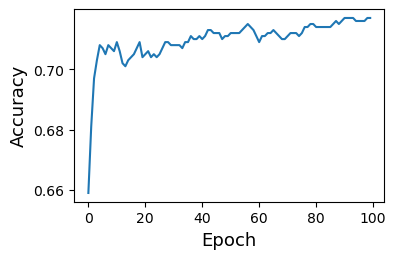

In [10]:
import pylab as pl
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

## Questions

* **Question 3 (1 pt):** Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.

* **Question 4 (1 pt):** Compare this GraphSage with models from Weekly Assignment 2.

* **Question 5 (2 pt):** Change the aggregation function to `max`. What's the default?

* **Question 6 (2 pt):** Add one more layer to the model and investigate the performance change.

* **Question 7 (2 pt):** Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

* **Question 8 (4 pt):** Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice.


Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix():
  model.eval()
  with torch.no_grad():
      out = model(dataset.data)
      preds = out.argmax(dim=1)[dataset.data.test_mask]
      actual = dataset.data.y[dataset.data.test_mask]

  res = confusion_matrix(actual, preds)
  sns.heatmap(res, annot=True, fmt='d', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

/home/vdubey/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


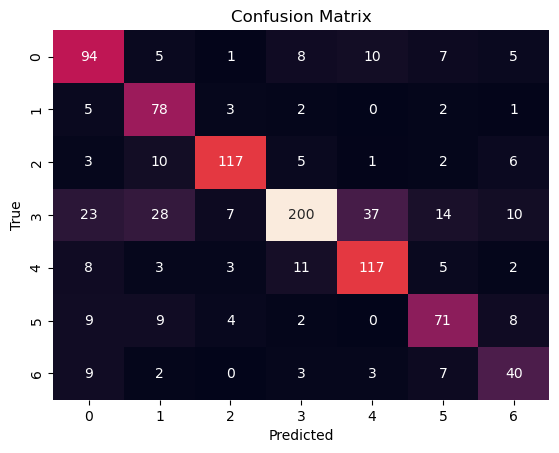

In [12]:
generate_confusion_matrix()

We can see that the model is pretty good at predicting when the true classes are 0, 1, 2, 4, 5, and 6. However, we see some confusion in predicting when the node has class 3. The model sometimes confuses these examples with being from classes 1, 2, or 4. This degree of errors is not present for any other class.

Compare this GraphSage with models from Weekly Assignment 2.

From a training loss standpoint: 
* Graph Sage - 0.01

* GCN - 0.0017

* Node2Vec Classifier - 0.55

After training, the GCN had the lowest training loss and GraphSage came in second.

Change the aggregation function to max. What's the default?

The default is mean.

In [13]:
class GraphSAGEMax(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels, aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGEMax(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

/home/vdubey/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.466
Accuracy on epoch 2: 0.604
Accuracy on epoch 3: 0.681
Accuracy on epoch 4: 0.708
Accuracy on epoch 5: 0.71
Accuracy on epoch 6: 0.716
Accuracy on epoch 7: 0.722
Accuracy on epoch 8: 0.725
Accuracy on epoch 9: 0.728
Accuracy on epoch 10: 0.724
Accuracy on epoch 11: 0.724
Accuracy on epoch 12: 0.721
Accuracy on epoch 13: 0.722
Accuracy on epoch 14: 0.721
Accuracy on epoch 15: 0.72
Accuracy on epoch 16: 0.72
Accuracy on epoch 17: 0.719
Accuracy on epoch 18: 0.717
Accuracy on epoch 19: 0.715
Accuracy on epoch 20: 0.714
Accuracy on epoch 21: 0.713
Accuracy on epoch 22: 0.713
Accuracy on epoch 23: 0.71
Accuracy on epoch 24: 0.707
Accuracy on epoch 25: 0.708
Accuracy on epoch 26: 0.706
Accuracy on epoch 27: 0.707
Accuracy on epoch 28: 0.707
Accuracy on epoch 29: 0.706
Accuracy on epoch 30: 0.706
Accuracy on epoch 31: 0.706
Accuracy on epoch 32: 0.707
Accuracy on epoch 33: 0.708
Accuracy on epoch 34: 0.709
Accuracy on epoch 35: 0.708
Accuracy on epoch 36: 0.708
Accur

In [14]:
res['max'] = accuracy

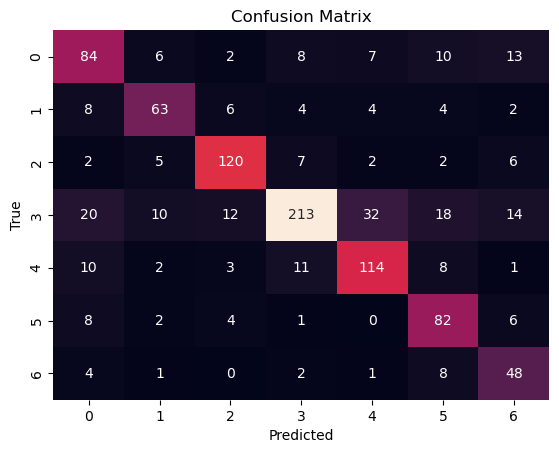

In [15]:
generate_confusion_matrix()

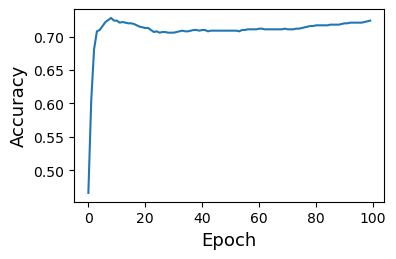

In [16]:
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

In [17]:
def plot_current_state():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    colors = plt.get_cmap('tab10')
    
    for idx, (key, values) in enumerate(res.items()):
        ax1.plot(values, label=key, color=colors(idx))
    
    ax1.set_title('Accuracies by Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    keys = list(res.keys())
    final_values = [values[-1] for values in res.values()]
    
    for idx, key in enumerate(keys):
        ax2.bar(key, final_values[idx], color=colors(idx))
    ax2.set_title('Final Accuracy')
    ax2.set_ylabel('Final Accuracy')
    ax2.set_ylim(0.5, 0.85)
    
    plt.tight_layout()
    plt.show()

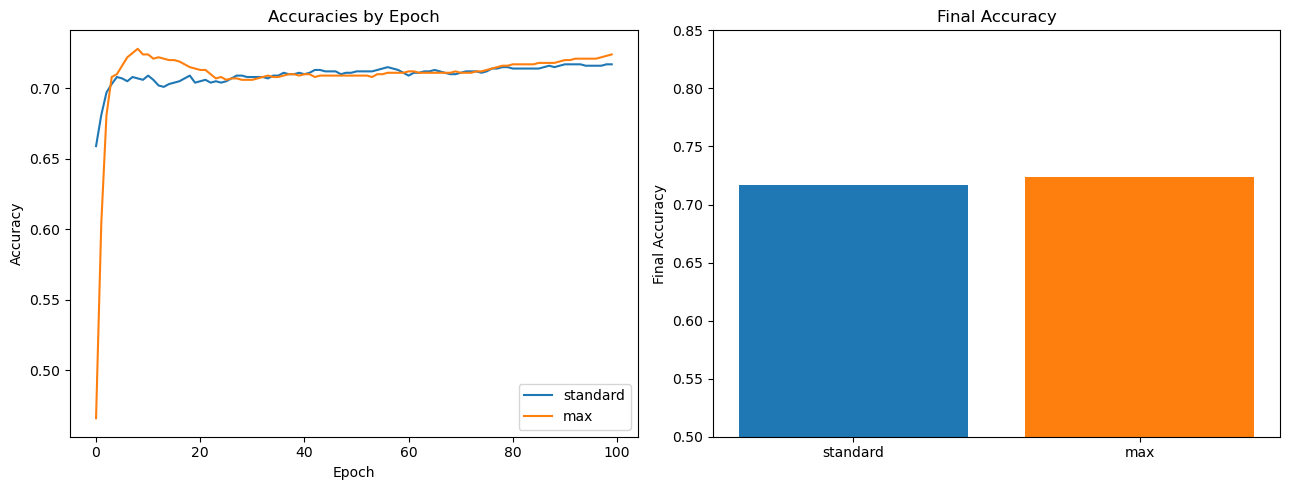

In [18]:
plot_current_state()

The accuracy in the model with the max aggregator is actually better than the default model with the mean aggregator. The model also performs better in predicting class 3. The default model predicts 199 of them right whereas this one predicts 215 of them correctly. However, the mistakes for this model are more spread apart across classes.

Add one more layer to the model and investigate the performance change.

In [19]:
class GraphSAGE2Layer(torch.nn.Module):
    def __init__(self, in_channels, num_hidden, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, num_hidden)
        self.conv2 = SAGEConv(num_hidden, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE2Layer(dataset.num_node_features, 500, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

/home/vdubey/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.771
Accuracy on epoch 2: 0.778
Accuracy on epoch 3: 0.778
Accuracy on epoch 4: 0.775
Accuracy on epoch 5: 0.771
Accuracy on epoch 6: 0.763
Accuracy on epoch 7: 0.759
Accuracy on epoch 8: 0.76
Accuracy on epoch 9: 0.75
Accuracy on epoch 10: 0.74
Accuracy on epoch 11: 0.738
Accuracy on epoch 12: 0.734
Accuracy on epoch 13: 0.727
Accuracy on epoch 14: 0.721
Accuracy on epoch 15: 0.711
Accuracy on epoch 16: 0.712
Accuracy on epoch 17: 0.711
Accuracy on epoch 18: 0.712
Accuracy on epoch 19: 0.718
Accuracy on epoch 20: 0.725
Accuracy on epoch 21: 0.736
Accuracy on epoch 22: 0.746
Accuracy on epoch 23: 0.753
Accuracy on epoch 24: 0.763
Accuracy on epoch 25: 0.771
Accuracy on epoch 26: 0.778
Accuracy on epoch 27: 0.782
Accuracy on epoch 28: 0.785
Accuracy on epoch 29: 0.795
Accuracy on epoch 30: 0.789
Accuracy on epoch 31: 0.788
Accuracy on epoch 32: 0.788
Accuracy on epoch 33: 0.787
Accuracy on epoch 34: 0.785
Accuracy on epoch 35: 0.78
Accuracy on epoch 36: 0.78
Accura

In [20]:
res['two_layer'] = accuracy

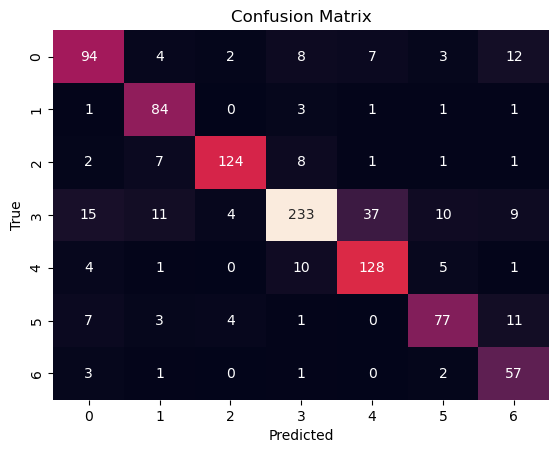

In [21]:
generate_confusion_matrix()

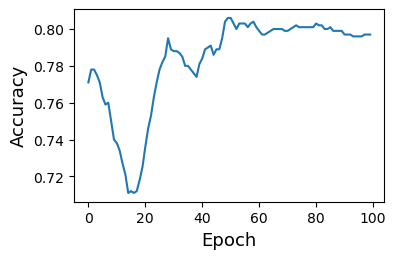

In [22]:
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

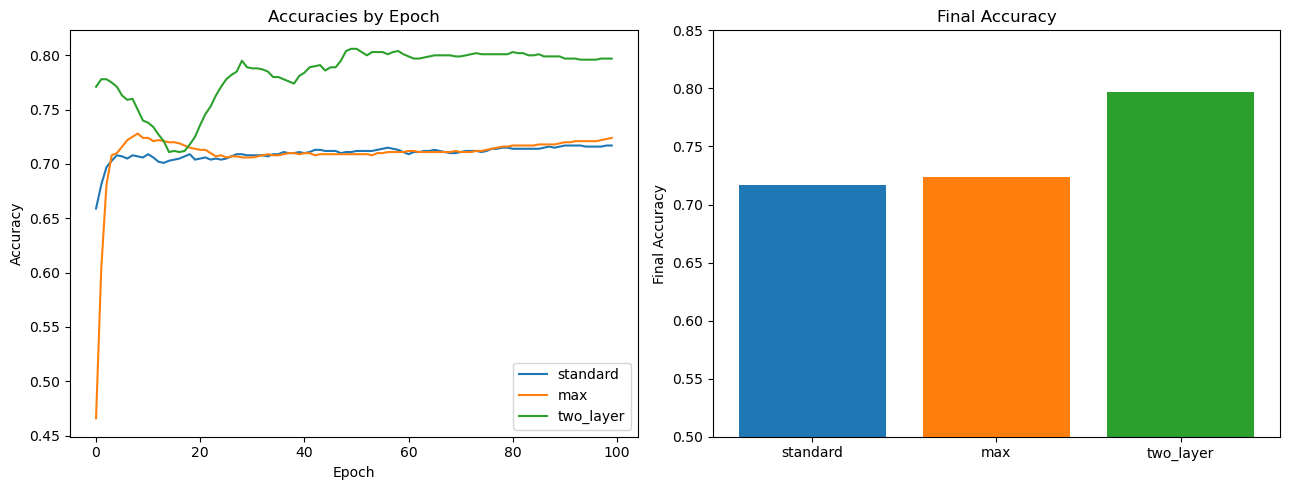

In [23]:
plot_current_state()

With the second layer, the accuracy of the model rises from around 0.72 to around 0.8. This is expected because the extra layer allows the model to capture more complex relationships present in the data. This is the best performing model so far. One thing I am having troubling understanding is why the accuracies decrease so quickly in the early epochs for the standard and two-layer models.

Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

In [24]:
class GraphSAGEDropout(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels)
        self.dropout = torch.nn.Dropout(0.15)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = self.dropout(x)
        return F.log_softmax(x, dim=1)

model = GraphSAGEDropout(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

/home/vdubey/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.503
Accuracy on epoch 2: 0.627
Accuracy on epoch 3: 0.666
Accuracy on epoch 4: 0.676
Accuracy on epoch 5: 0.686
Accuracy on epoch 6: 0.688
Accuracy on epoch 7: 0.69
Accuracy on epoch 8: 0.694
Accuracy on epoch 9: 0.696
Accuracy on epoch 10: 0.696
Accuracy on epoch 11: 0.697
Accuracy on epoch 12: 0.698
Accuracy on epoch 13: 0.697
Accuracy on epoch 14: 0.697
Accuracy on epoch 15: 0.698
Accuracy on epoch 16: 0.699
Accuracy on epoch 17: 0.705
Accuracy on epoch 18: 0.705
Accuracy on epoch 19: 0.703
Accuracy on epoch 20: 0.703
Accuracy on epoch 21: 0.703
Accuracy on epoch 22: 0.704
Accuracy on epoch 23: 0.704
Accuracy on epoch 24: 0.704
Accuracy on epoch 25: 0.701
Accuracy on epoch 26: 0.7
Accuracy on epoch 27: 0.702
Accuracy on epoch 28: 0.704
Accuracy on epoch 29: 0.701
Accuracy on epoch 30: 0.702
Accuracy on epoch 31: 0.704
Accuracy on epoch 32: 0.703
Accuracy on epoch 33: 0.703
Accuracy on epoch 34: 0.701
Accuracy on epoch 35: 0.7
Accuracy on epoch 36: 0.699
Accura

In [25]:
res['dropout'] = accuracy

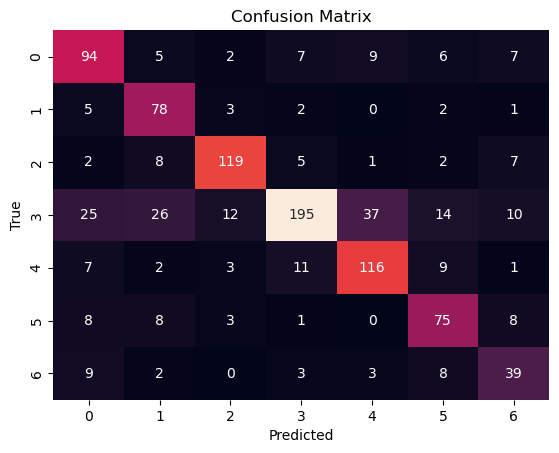

In [26]:
generate_confusion_matrix()

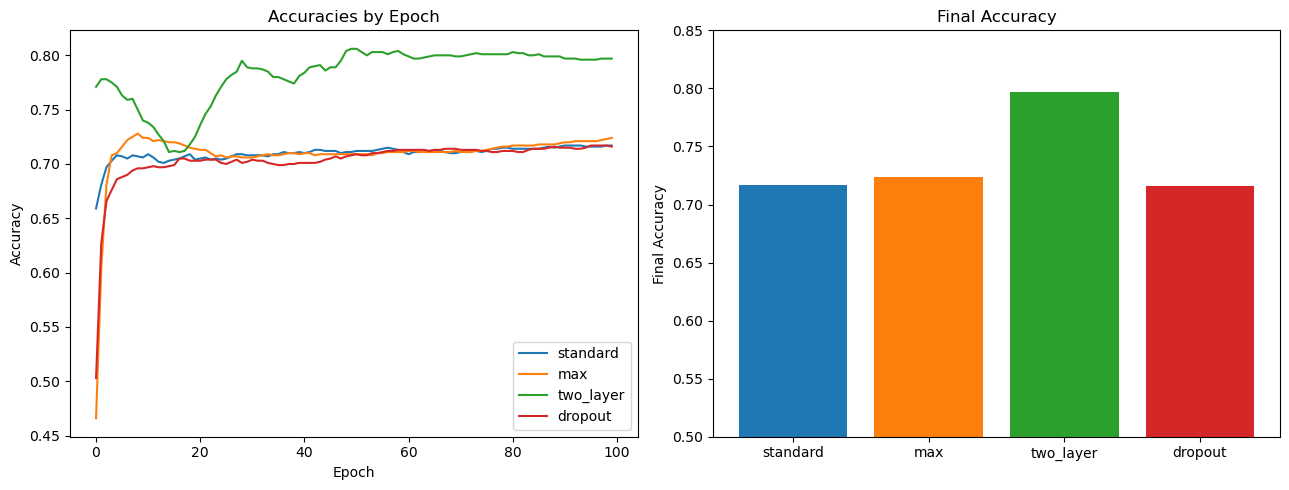

In [27]:
plot_current_state()

In [28]:
class GraphSAGE2LayerDropout(torch.nn.Module):
    def __init__(self, in_channels, num_hidden, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, num_hidden)
        self.conv2 = SAGEConv(num_hidden, out_channels)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE2LayerDropout(dataset.num_node_features, 500, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

/home/vdubey/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.744
Accuracy on epoch 2: 0.782
Accuracy on epoch 3: 0.783
Accuracy on epoch 4: 0.777
Accuracy on epoch 5: 0.777
Accuracy on epoch 6: 0.771
Accuracy on epoch 7: 0.77
Accuracy on epoch 8: 0.768
Accuracy on epoch 9: 0.763
Accuracy on epoch 10: 0.759
Accuracy on epoch 11: 0.753
Accuracy on epoch 12: 0.751
Accuracy on epoch 13: 0.747
Accuracy on epoch 14: 0.743
Accuracy on epoch 15: 0.739
Accuracy on epoch 16: 0.736
Accuracy on epoch 17: 0.735
Accuracy on epoch 18: 0.732
Accuracy on epoch 19: 0.735
Accuracy on epoch 20: 0.738
Accuracy on epoch 21: 0.74
Accuracy on epoch 22: 0.745
Accuracy on epoch 23: 0.748
Accuracy on epoch 24: 0.756
Accuracy on epoch 25: 0.765
Accuracy on epoch 26: 0.774
Accuracy on epoch 27: 0.775
Accuracy on epoch 28: 0.778
Accuracy on epoch 29: 0.778
Accuracy on epoch 30: 0.78
Accuracy on epoch 31: 0.784
Accuracy on epoch 32: 0.789
Accuracy on epoch 33: 0.793
Accuracy on epoch 34: 0.793
Accuracy on epoch 35: 0.795
Accuracy on epoch 36: 0.79
Accur

In [29]:
res['dropout_2layer'] = accuracy

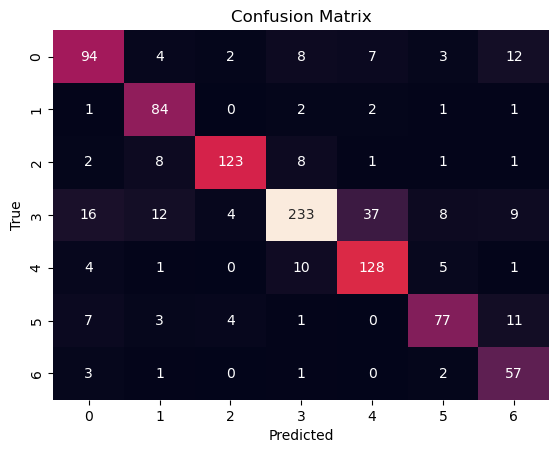

In [30]:
generate_confusion_matrix()

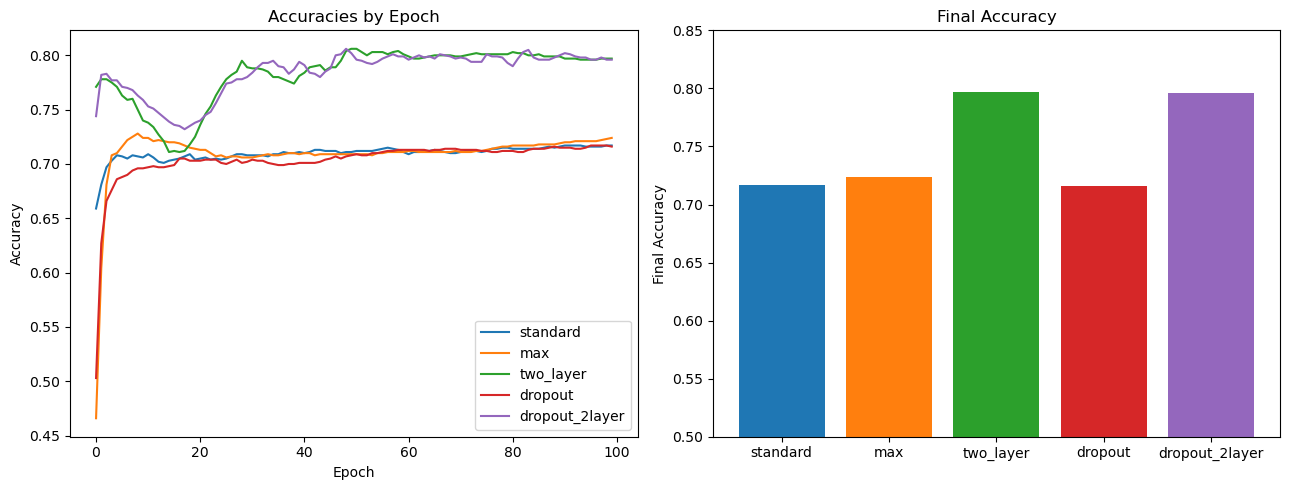

In [31]:
plot_current_state()

Dropout at 0.15 slightly improves the accuracies when compared to the non-dropout counterpart. This improvement isn't be a lot though as can be seen from the bar charts. Theoretically speaking, dropout should improve the ROC curve of a classifier because it improves the model's ability to generalize. I wasn't too sure how to plot a ROC curve for a multi-class classification task as I mostly have seen it used for binary classification.

Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice.

The dataset I chose is called BlogCatalog. It is a network where the nodes are the users of a certain blog and an edge between two nodes exists if they are friends. The goal of the classification problem is to classify the users into 1 of 6 categories.

In [32]:
from torch_geometric.datasets import AttributedGraphDataset

dataset = AttributedGraphDataset(root='./data', name='BlogCatalog')

data = dataset[0]
num_nodes = data.num_nodes

num_test = int(num_nodes * 0.2)
test_bools = torch.cat([torch.ones(num_test, dtype=torch.bool),
                        torch.zeros(num_nodes - num_test, dtype=torch.bool)])

test_bools = test_bools[torch.randperm(test_bools.size(0))]
data.train_mask = ~test_bools
data.test_mask = test_bools

In [33]:
model = GraphSAGE(data.num_node_features, 6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [34]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[data.test_mask] == data.y[data.test_mask]
        acc = int(flag_is_correct.sum()) / int(data.test_mask.sum())
        return acc

In [35]:
accuracy = []
for epoch in range(40):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.5543792107795957
Accuracy on epoch 2: 0.9104908565928778
Accuracy on epoch 3: 0.9249278152069298
Accuracy on epoch 4: 0.9364773820981713
Accuracy on epoch 5: 0.9355149181905679
Accuracy on epoch 6: 0.9345524542829644
Accuracy on epoch 7: 0.944177093358999
Accuracy on epoch 8: 0.9538017324350336
Accuracy on epoch 9: 0.9547641963426372
Accuracy on epoch 10: 0.9615014436958614
Accuracy on epoch 11: 0.9663137632338787
Accuracy on epoch 12: 0.9643888354186718
Accuracy on epoch 13: 0.9653512993262753
Accuracy on epoch 14: 0.9653512993262753
Accuracy on epoch 15: 0.9643888354186718
Accuracy on epoch 16: 0.9634263715110684
Accuracy on epoch 17: 0.9643888354186718
Accuracy on epoch 18: 0.9624639076034649
Accuracy on epoch 19: 0.9653512993262753
Accuracy on epoch 20: 0.9653512993262753
Accuracy on epoch 21: 0.9663137632338787
Accuracy on epoch 22: 0.9672762271414822
Accuracy on epoch 23: 0.9701636188642926
Accuracy on epoch 24: 0.971126082771896
Accuracy on epoch 25: 0.970

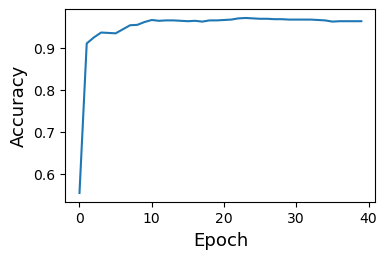

In [36]:
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

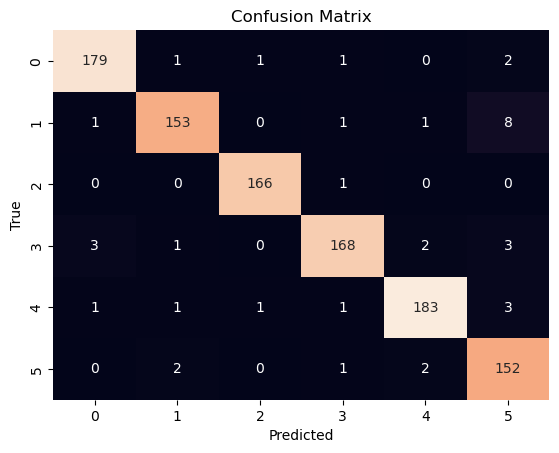

In [37]:
model.eval()
with torch.no_grad():
  out = model(data)
  preds = out.argmax(dim=1)[data.test_mask]
  actual = data.y[data.test_mask]

res = confusion_matrix(actual, preds)
sns.heatmap(res, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

As you can see the simple 1-layer, no dropout GraphSage model performs really well in this task, reaching more than 96% accuracy on the test set. It predicts each class pretty uniformly well also.

Good luck! :)